# Estimating country means (different debiasing methods)

### TODO: Rewrite markdown. The comments don't fit the content at the moment. Choosing to push to Github either way for safekeeping.

Ultimately, retrieving the ATE can be seen as determining the (possibly weighted) means of two subsets: treated and control. As we will see, using the mean of model predictions for the subset, $\mathbb{E}[\hat{Y} \mid i \in S]$, will be a biased estimate of $\mathbb{E}[Y \mid i \in S]$ due to $Y - \hat{Y} \not\perp Y$. To study this phenomenon, we would like to estimate the mean of some of subsets with and without our Tweedies' based debiasing formula. The subsets need to be meaningful, so in this notebook we will make use of the country labels to estimate the mean IWI for each country. The hypothesis is that the mean of the predicted estimates will be biased in regards to the true wealth, such that the predicted mean will be too high for poor countries and too low for rich countries. The hope is for the Tweedie's adjusted predictions to remove this bias.

In [1]:
import os
import configparser
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from utils import RegressionModel, train_model, plot_results
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_theme()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the image embeddings and DHS information for our small dataset (10k entries). Randomly split into training and test set.

In [2]:
RANDOM_STATE = 42
N_COMPONENTS = 232

embeddings = np.load(os.path.join(DATA_DIR, 'small_ssl4eo_resnet50.npy'))
df = pd.read_csv(os.path.join(DATA_DIR, 'small_dhs.csv'))

assert embeddings.shape[0] == df.shape[0], 'Mismatch between embeddings and metadata rows.'

X = embeddings

# Cheat by doing rescaling and PCA on the whole set
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=N_COMPONENTS)
X = pca.fit_transform(X)

Y = df['iwi'].values / 100.0 # Scale IWI to [0, 1]
Y = Y.clip(0, 1)

X = torch.tensor(X, dtype=torch.float).to(device)
Y = torch.tensor(Y, dtype=torch.float).to(device)

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, Y, df, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val, df_train, df_val = train_test_split(X_train, y_train, df_train, test_size=0.2, random_state=RANDOM_STATE)

Train NN model with MSE using the training set.

  5%|▍         | 2269/50000 [00:11<04:01, 197.64it/s]
/cephyr/users/markpett/Alvis/ImputeAwareATE/real_data_experiments/utils.py:338: RuntimeWarning: invalid value encountered in log
  log_pred = np.log(log_model.predict(x_values))  # Convert back to original scale


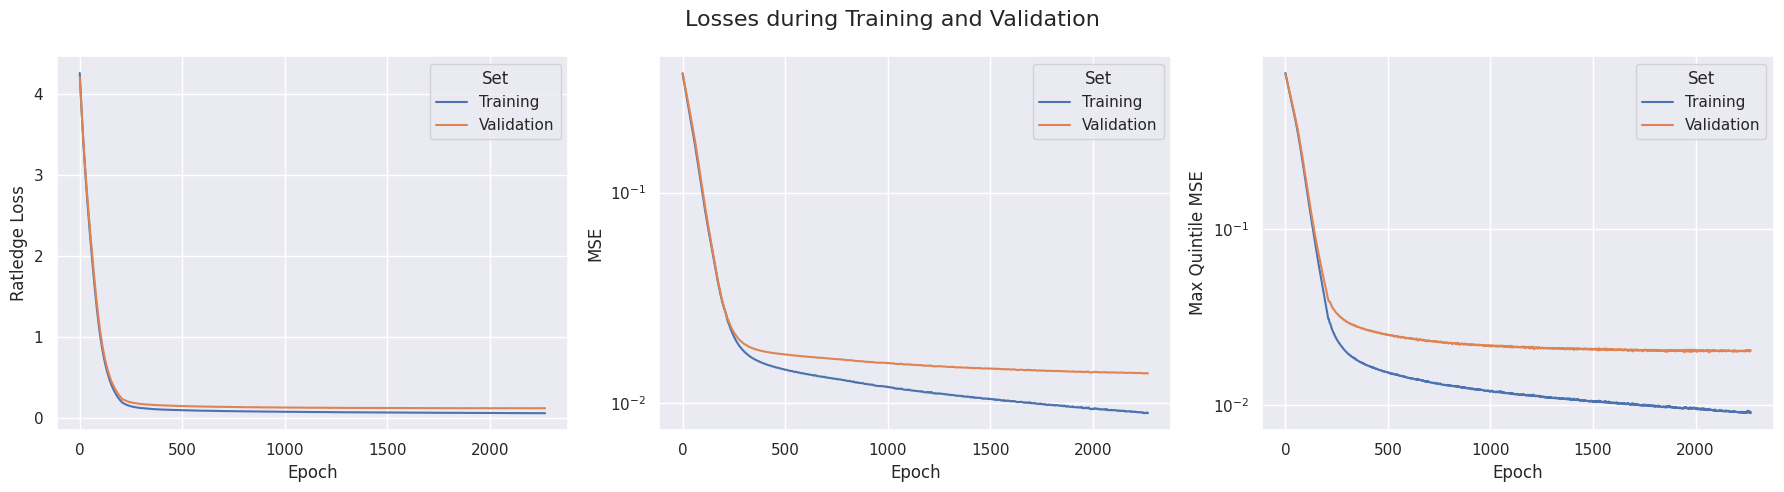

 13%|█▎        | 6399/50000 [00:14<01:41, 428.95it/s]


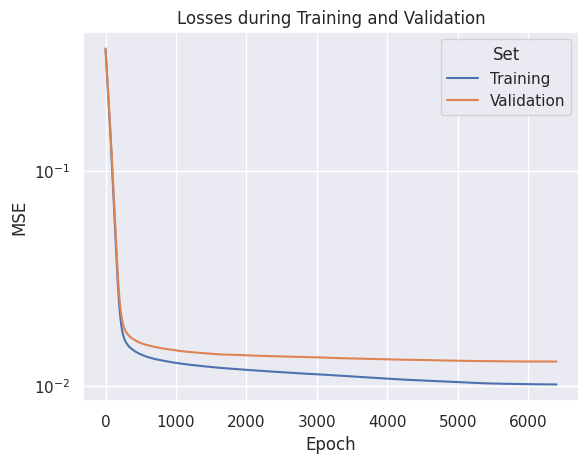

In [3]:
def max_mse_by_quintile(pred, target):
    # Get the quintile boundaries (0%, 20%, 40%, 60%, 80%, 100%)
    quantiles = torch.quantile(target, torch.tensor([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]).cuda())

    max_quintile_mse = torch.tensor(float('-inf')).cuda()

    for i in range(5):
        lower = quantiles[i]
        upper = quantiles[i+1]
        
        # Create mask for current quintile
        if i < 4:
            mask = (target >= lower) & (target < upper)
        else:
            mask = (target >= lower) & (target <= upper)

        # Calculate MSE for the current quintile
        if mask.sum() > 0:
            mse = nn.MSELoss()(pred[mask], target[mask])
        else:
            mse = torch.tensor(float('-inf')).cuda()  # So it won't affect max if empty

        if mse > max_quintile_mse:
            max_quintile_mse = mse

    # Get the max MSE
    return max_quintile_mse

lambda_b = 5
lambda_r = 1e-2
lr = 1e-4

# Example of a loss function that only tracks one metric (MSE)
def ratledge_loss(pred, target):
    mse = nn.MSELoss()(pred, target)
    max_quintile_mse = max_mse_by_quintile(pred, target)
    loss = mse + lambda_b * max_quintile_mse
    return loss, {'Ratledge Loss': loss.item(), 'MSE': mse.item(), 'Max Quintile MSE': max_quintile_mse.item()}

ratledge_model = train_model(X_train, X_val, y_train, y_val, lr=lr, l2=lambda_r, loss_fn=ratledge_loss, verbose=1)

def mse_loss(pred, target):
    mse = nn.MSELoss()(pred, target)
    return mse, {'MSE': mse.item()}

mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=mse_loss, verbose=1)

Plot results for the test set. We will see a positive correlation between $Y$ and $Y - \hat{Y}$, suggesting that we overestimate the wealth of poor location and underestimate for wealth loications.

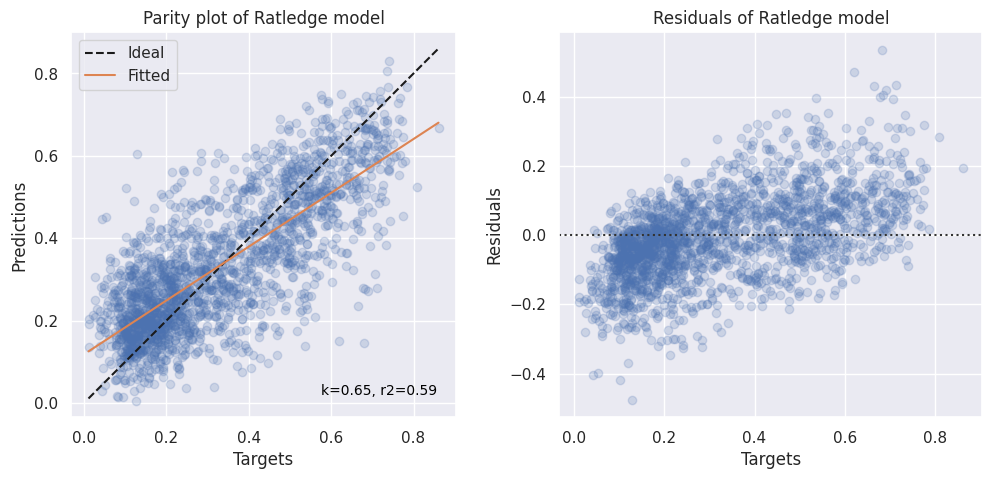

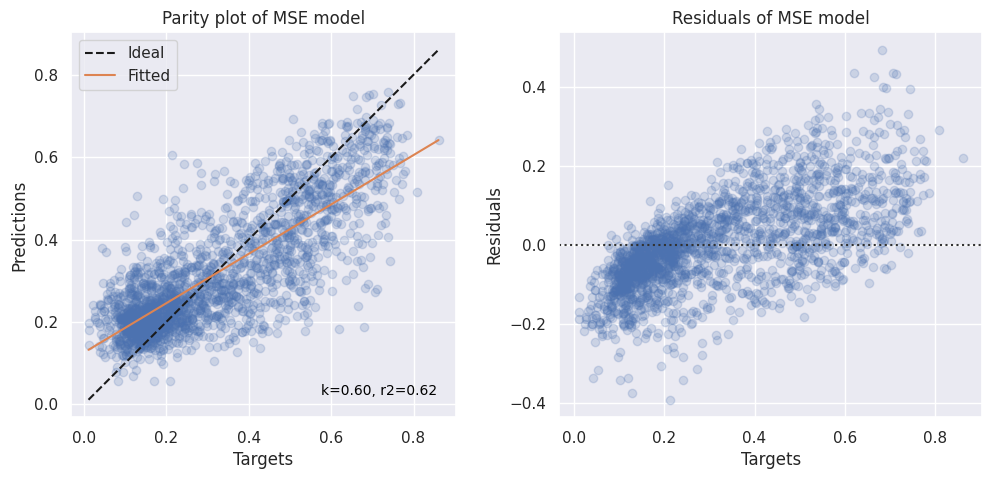

In [4]:
with torch.no_grad():
    ratledge_pred = ratledge_model(X_test)
    
plot_results(y_test, ratledge_pred, 'Ratledge model')

with torch.no_grad():
    mse_pred = mse_model(X_test)
    
plot_results(y_test, mse_pred, 'MSE model')

Rescale IWI to [0, 100]

In [5]:
targets = 100 * y_test.cpu().numpy()
ratledge_predictions = 100 * ratledge_pred.cpu().numpy()
mse_predictions = 100 * mse_pred.cpu().numpy()

In [6]:
with torch.no_grad():
    val_predictions = mse_model(X_val).cpu().numpy()
    val_targets = y_val.cpu().numpy()
    val_predictions = val_predictions * 100
    val_targets = val_targets * 100

    res_std = (val_predictions - val_targets).std()

print('Var(Y - Y-hat):', res_std)

Var(Y - Y-hat): 11.368018


Calculate the score for each predicted point

In [7]:
from scipy.stats import gaussian_kde

pred_kde = gaussian_kde(val_predictions)

def score_function(y, kde, delta=1e-5):
    # Derivative of log density
    log_p_plus = kde.logpdf(y + delta)[0]
    log_p_minus = kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    return d_logp

prediction_scores = np.array([score_function(y, pred_kde) for y in mse_predictions])

Calculate the coefficients of the $km$ regressor for the linear adjustment

In [9]:
from sklearn.linear_model import LinearRegression

km_regressor = LinearRegression()
km_regressor.fit(val_targets.reshape(-1, 1), val_predictions)

k = km_regressor.coef_[0]
m = km_regressor.intercept_
print(f'Estimated slope (k): {k:.4f}')
print(f'Estimated intercept (m): {m:.4f}')

km_predictions = (mse_predictions - m) / k

Estimated slope (k): 0.6239
Estimated intercept (m): 11.7894


Calculate five means for each country:

- The mean of the labels $Y$
- The mean of the MSE predictions $\hat{Y}$
- The mean of the MSE predictions adjusted by our "Tweedie's adjustment"
- The mean of the MSE predictions adjusted by our "$km$ adjustment"
- The mean of the Ratledge model predictions


In [10]:
countries = df_test['country'].unique()

target_means = []
prediction_means = []
adjusted_prediction_means = []
ratledge_prediction_means = []
km_prediction_means = []

for country in countries:
    country_mask = df_test['country'] == country

    country_target_mean = targets[country_mask].mean()
    country_pred_mean = mse_predictions[country_mask].mean()
    country_ratledge_mean = ratledge_predictions[country_mask].mean()

    adjusted_pred_country_mean = country_pred_mean - res_std**2 * prediction_scores[country_mask].mean()
    km_pred_country_mean = (country_pred_mean - m) / k

    target_means.append(country_target_mean)
    prediction_means.append(country_pred_mean)
    adjusted_prediction_means.append(adjusted_pred_country_mean)
    ratledge_prediction_means.append(country_ratledge_mean)
    km_prediction_means.append(km_pred_country_mean)

target_means = np.array(target_means)
prediction_means = np.array(prediction_means)
adjusted_prediction_means = np.array(adjusted_prediction_means)
ratledge_prediction_means = np.array(ratledge_prediction_means)
km_prediction_means = np.array(km_prediction_means)

Plot the true country means (from $Y$) vs the predicted means with and without Tweedie's adjustment.

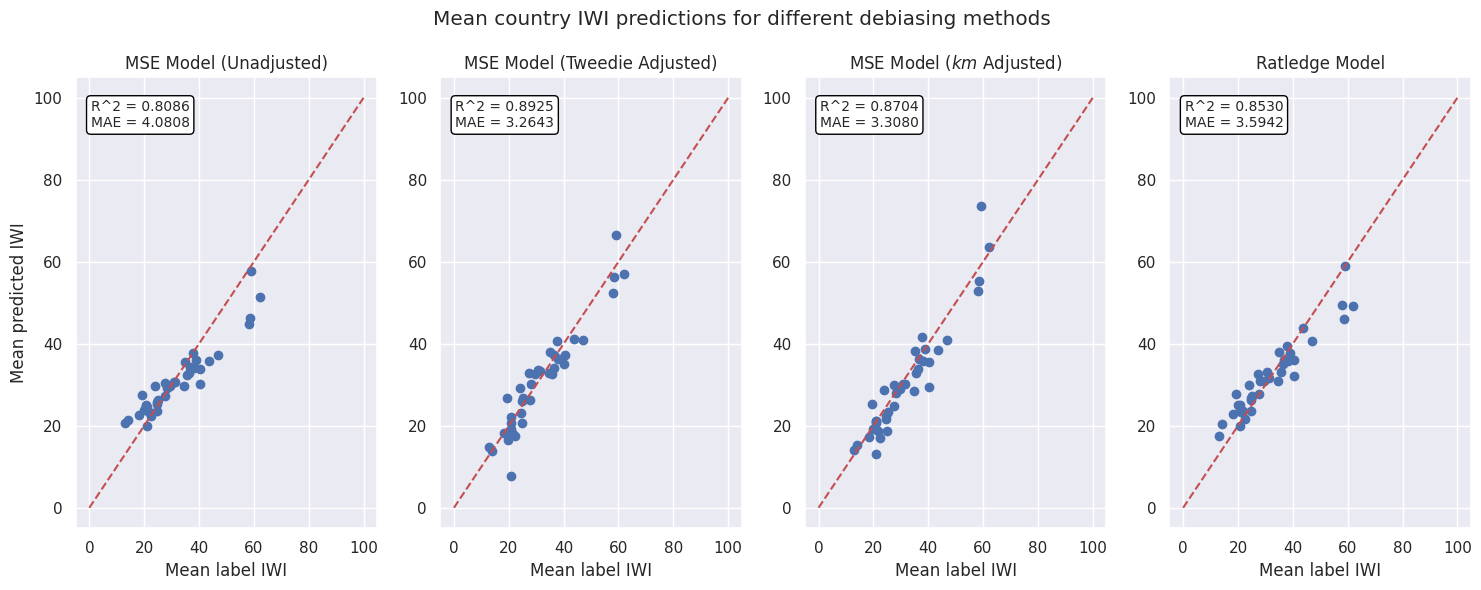

In [11]:
# Plot the target vs prediction means
plt.figure(figsize=(15, 6))
plt.subplot(1, 4, 1)
plt.scatter(target_means, prediction_means)
# Add label with r^2 and MAE to plot
r2 = r2_score(target_means, prediction_means)
mae = mean_absolute_error(target_means, prediction_means)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Mean label IWI')
plt.ylabel('Mean predicted IWI')
plt.title('MSE Model (Unadjusted)')

plt.subplot(1, 4, 2)
plt.scatter(target_means, adjusted_prediction_means)
# Add label with r^2 and MAE to plot
r2 = r2_score(target_means, adjusted_prediction_means)
mae = mean_absolute_error(target_means, adjusted_prediction_means)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Mean label IWI')
#plt.ylabel('Tweedies Adjusted Predicted Mean IWI')
plt.title('MSE Model (Tweedie Adjusted)')

plt.subplot(1, 4, 3)
plt.scatter(target_means, km_prediction_means)
# Add label with r^2 and MAE to plot
r2 = r2_score(target_means, km_prediction_means)
mae = mean_absolute_error(target_means, km_prediction_means)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Mean label IWI')
#plt.ylabel('km Adjusted Predicted Mean IWI')
plt.title('MSE Model ($km$ Adjusted)')

plt.subplot(1, 4, 4)
plt.scatter(target_means, ratledge_prediction_means)
# Add label with r^2 and MAE to plot
r2 = r2_score(target_means, ratledge_prediction_means)
mae = mean_absolute_error(target_means, ratledge_prediction_means)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Mean label IWI')
#plt.ylabel('Ratledge Predicted Mean IWI')
plt.title('Ratledge Model')
plt.suptitle('Mean country IWI predictions for different debiasing methods')
plt.tight_layout()
plt.show()

In [12]:
from scipy.stats import f
from sklearn.linear_model import LinearRegression

def f_statistic(X, Y):

    n = len(Y)

    # Restricted model: Y = X (slope fixed at 1, intercept fixed at 0)
    RSS_R = np.sum((Y - X)**2)

    # Unrestricted model: Estimate slope (k) and intercept (m)
    reg = LinearRegression()
    reg.fit(X.reshape(-1, 1), Y)
    fitted_Y = reg.predict(X.reshape(-1, 1))
    RSS_UR = np.sum((Y - fitted_Y)**2)

    # 3. Compute the F statistic
    q = 2  # number of restrictions: m=0 and k=1
    p = 2  # parameters in unrestricted model
    F_stat = ((RSS_R - RSS_UR) / q) / (RSS_UR / (n - p))

    # Compute the p-value for the F-test
    p_value = 1 - f.cdf(F_stat, q, n - p)

    print(f'Estimated slope (k):, {reg.coef_[0]:.4f}')
    print(f'Estimated intercept (m):, {reg.intercept_:.4f}')
    print(f'RSS of Restricted model (k=1, m=0):, {RSS_R:.4f}')
    print(f'RSS of Unrestricted model:, {RSS_UR:.4f}')
    print(f'F-statistic:, {F_stat:.4f}')
    print(f'p-value:, {p_value:.4f}')

print("F-statistic for target vs prediction means:")
f_statistic(target_means, prediction_means)
print('')
print("F-statistic for target vs adjusted prediction means:")
f_statistic(target_means, adjusted_prediction_means)

print("F-statistic for Target vs MSE Model (Unadjusted):")
f_statistic(target_means, prediction_means)
print('')
print("F-statistic for Target vs MSE Model (Tweedie Adjusted):")
f_statistic(target_means, adjusted_prediction_means)
print('')
print("F-statistic for Target vs MSE Model (km Adjusted):")
f_statistic(target_means, km_prediction_means)
print('')
print("F-statistic for Target vs Ratledge Model:")
f_statistic(target_means, ratledge_prediction_means)

F-statistic for target vs prediction means:
Estimated slope (k):, 0.6277
Estimated intercept (m):, 10.8977
RSS of Restricted model (k=1, m=0):, 1133.6826
RSS of Unrestricted model:, 276.2229
F-statistic:, 55.8762
p-value:, 0.0000

F-statistic for target vs adjusted prediction means:
Estimated slope (k):, 0.9515
Estimated intercept (m):, 0.8152
RSS of Restricted model (k=1, m=0):, 636.9705
RSS of Unrestricted model:, 602.7664
F-statistic:, 1.0214
p-value:, 0.3703
F-statistic for Target vs MSE Model (Unadjusted):
Estimated slope (k):, 0.6277
Estimated intercept (m):, 10.8977
RSS of Restricted model (k=1, m=0):, 1133.6826
RSS of Unrestricted model:, 276.2229
F-statistic:, 55.8762
p-value:, 0.0000

F-statistic for Target vs MSE Model (Tweedie Adjusted):
Estimated slope (k):, 0.9515
Estimated intercept (m):, 0.8152
RSS of Restricted model (k=1, m=0):, 636.9705
RSS of Unrestricted model:, 602.7664
F-statistic:, 1.0214
p-value:, 0.3703

F-statistic for Target vs MSE Model (km Adjusted):
Estim